# Task: Model the dynamics of gender in intro CS


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries


import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns
import tools
import inputData
   
plt.style.use('ggplot')

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
dataset = inputData.preprocess()

In [4]:
dataset = dataset.query('gender == "Female" or gender == "Male"')
dataset = dataset.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(dataset.query('gender == "Male"')), ' male students, and ',
                                  len(dataset.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


#### Drop the columns that aren't needed for the model

In [5]:
columnsNotNeeded = ['timestamp', 'consent','name', 'name_1', 'name_2', 
                    'morecs','snap_python','hiphop_d1','hiphop_d2','song_ct', 'major'] 
dataset.drop(columnsNotNeeded, axis=1, inplace=True)
                   

## Preprocess Data

### Preprocess feature columns
To prepare our data for classification, we need to devise a scheme to transform all features into numeric data. This dataset as several non-numeric columns that need converting. Many of them are simply `yes`/`no`, e.g. `prcs_2`. We can reasonably convert these into `1`/`0` (binary) values. For the columns whose values are `Nan`, we will convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
dataset = preprocess_features(dataset)
print "Processed feature columns ({}):- {}".format(len(dataset.columns), list(dataset.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Preprocess feature columns - Rename columns

There are some columns that have spaces in their names, these makes it difficult for the tree plotting algorithms that we will be using later to graph these features. As a result, we will change these spaces to hypens.

In [8]:
dataset.rename(columns = {'grade_B or above':'grade_B_or_above'}, inplace = True)
dataset.rename(columns = {'grade_B or below':'grade_B_or_below'}, inplace = True)

### Assign features to dimension

We are assigning features to dimensions to support analysis and interpretability of the model.


| Code|  Dimension|
| ------------- |-------------|
|atcs |Attitudes about CS competency.|
|atcsgender |Attitudes about the role of gender in computer science.|
|atct |Understanding of computational thinking.|
|blg |Sense of belonging in the CS classroom.|
|clet |Attitudes about social implications and ethics. |
|cltrcmp |Understanding around cultural competency.|
|mtr |Access to CS Mentors.|
|prcs |Pre-Collegiate computer science awareness.|


In [9]:
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
gender = ['gender_Female', 'gender_Male' ]
atcsgender = ['atcsgender_1','atcsgender_2','atcsgender_3'] 
atcsjob = ['atcsjob_1','atcsjob_2']
clet = ['clet_1','clet_2']
cltrcmp = ['cltrcmp_1','cltrcmp_2']
mtr = ['mtr_1','mtr_2','mtr_3']
prepared = ['prepared']

itemDimensions = {}
itemDimensions['atcs'] = atcs
itemDimensions['atct'] = atct
itemDimensions['blg'] = blg
itemDimensions['gender'] = gender
itemDimensions['atcsgender'] = atcsgender
itemDimensions['atcsjob'] = atcsjob
itemDimensions['clet'] = clet
itemDimensions['cltrcmp'] = cltrcmp
itemDimensions['mtr'] = mtr
itemDimensions['prepared'] = prepared

list_of_lists = [
itemDimensions['atcs'], 
itemDimensions['blg'],
itemDimensions['atct'],
itemDimensions['gender'],
itemDimensions['atcsgender'],
itemDimensions['atcsjob'],
itemDimensions['clet'],
itemDimensions['cltrcmp'],
itemDimensions['mtr'],   
itemDimensions['prepared']
]

flattened = [val for sublist in list_of_lists for val in sublist]

In [10]:
for key in itemDimensions:
    try:
        inputData.describeData(itemDimensions[key])
    except:
        print"{:15}{:20}".format(key, 'Preprocessed feature, no description')

atct_1         I am good at solving a problem by thinking about similar problems I’ve solved before.
atct_2         I have good research skills.
atct_3         I am good at using online search tools.
atct_4         I am persistent at solving puzzles or logic problems.
atct_5         I know how to write computer programs
atct_6         I am good at building things.
atct_7         I’m good at ignoring irrelevant details to solve a problem.
atct_8         I know how to write a computer program to solve a problem.
atcsgender_1   Women are less capable of success in CS than men.
atcsgender_2   Women are smarter than men.
atcsgender_3   Men have better math and science abilities than women.
atcs_1         I like to use computer science to solve problems.
atcs_2         I can learn to understand computing concepts.
atcs_3         I can achieve good grades (C or better) in computing courses.
atcs_4         I do not like using computer science to solve problems.
atcs_5         I am confident th

### Scaling
Linearly scale each attribute to the range [0, 1].



In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
dataset = df_scaled
dataset.tail()


,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.0,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,1.0,0.0


### Extract features and labels 

Extract feature (X) and target (y) columns

In [12]:
target_col = dataset['gender_Female']  #  column is the target/label 
y = target_col  # corresponding targets/labels

print "\nLabel values:-"
print y.head()  


Label values:-
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: gender_Female, dtype: float64


In [13]:
X = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X.head()  


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   atcsgender_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
0           0.0         ...            0.0     0.0     0.0     0.0     0.0   
1           0.0         ...            0.0     0.0     0.0     1.0     1.0   
2           0.0         ...            1.0     0.0     0.0     0.0     0.0   
3           0.0         ...            0.0     0.0     0.0     0.0     0.0   
4           0.0         ...            0.0     0.0     0.0     0.0     0.0   

   prcs_5  prepared  priorcs10  reason_class_Inter

In [14]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'grade_B_or_above', 'grade_B_or_below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


### Determine if classes are balanced
- As we can see the dataset is unbalanced, we have more males than females.




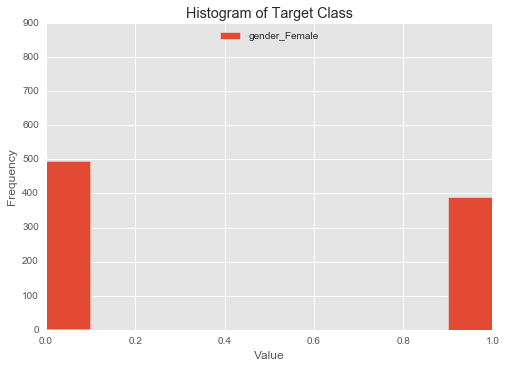

In [92]:
y.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of Target Class')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))
pyplt.savefig('report/figures/targetClass.png')


## Feature Transformation
We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe students.

In [16]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca_data = dataset.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

pca = PCA(n_components=30)
pca.fit(pca_data)


PCA(copy=True, n_components=30, whiten=False)

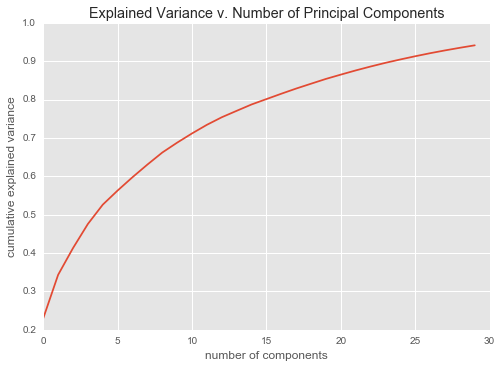

In [109]:
#Explained variance


fig, ax = pyplt.subplots()

_= pyplt.plot(np.cumsum(pca.explained_variance_ratio_))
_= pyplt.title('Explained Variance v. Number of Principal Components')
_= pyplt.xlabel('number of components')
_= pyplt.ylabel('cumulative explained variance')
_= pyplt.show()

fig.savefig('report/figures/explainedVariance.pdf', format='pdf', dpi=100)








In [18]:

print("Projecting the input data on the eigenfaces orthonormal basis")
X_pca = pca.transform(X)

Projecting the input data on the eigenfaces orthonormal basis


In [55]:
X_pca = pd.DataFrame(X_pca)

In [20]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [21]:
num_train

662

In [22]:
from sklearn import cross_validation



def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    
    


    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [27]:
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


In [28]:
X_pca_train, y_pca_train, X_pca_test, y_pca_test = shuffle_split_data(X_pca, y)
print "Training set: {} samples".format(X_pca_train.shape[0])
print "Test set: {} samples".format(X_pca_test.shape[0])

Training set: 662 samples
Test set: 220 samples


## Modeling and Validating




I have created four separate tranches to investigate the data:
- All features
- PCA transformed features
- A reduced dataset of features
- All features with the exception of gendered features removed

## Train on all features

In [74]:
X = X_train

seed = 342 # For reproducability
np.random.seed(seed)

In [80]:

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score


models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': tree.DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [76]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X, y_train, cv=kfold)
    print("Training data accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
   

RandomForest
Training data accuracy: 64.56% (12.63%) 

DecisionTree
Training data accuracy: 60.20% (11.12%) 

XGBoost
Training data accuracy: 67.95% (11.20%) 

SVC
Training data accuracy: 68.14% (11.05%) 



### Predict 

In [77]:
Features_test = X_test

for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

RandomForest
Testing data prediction accuracy: 63.64% 

DecisionTree
Testing data prediction accuracy: 55.91% 

XGBoost
Testing data prediction accuracy: 72.27% 

SVC
Testing data prediction accuracy: 64.55% 



#### Generate Features from XGBoost classifier 

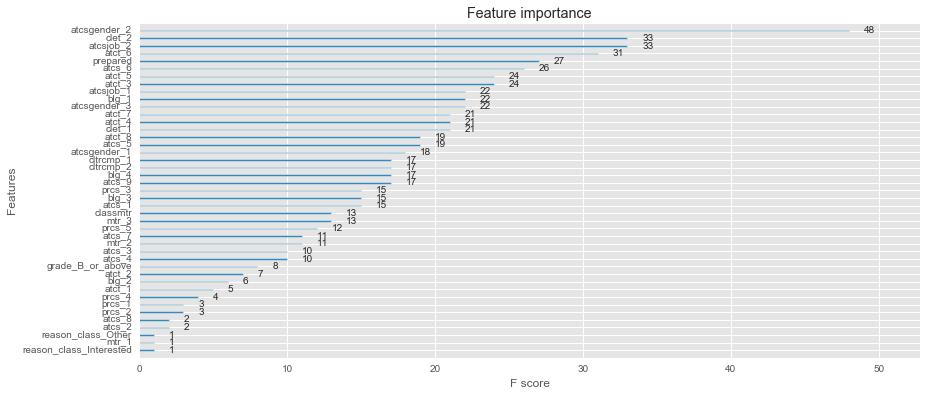

In [146]:
# plot feature importance
from xgboost import plot_importance

model = XGBClassifier()
model.fit(X, y_train)




plot_importance(model)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(14, 6)
fig.savefig('report/figures/feature_importance_xgb.pdf', dpi=100)

In [79]:
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_graph.gv', view=True)
    

'report/figures/X_graph.gv.pdf'

## Train on a reduced set of features

In [35]:
# Extract feature (X) and target (y) columns


X_all_Reduced = X_train[[ 
                'atcsgender_2', 'atcsgender_3', 
                'atcs_1', 'atcs_8',
                'cltrcmp_2', 'atcsjob_2', 'clet_2', 'atct_3',
                'blg_1', 'atcsgender_1']]


print "\nFeature values:-"
print X_all_Reduced.head()  


Feature values:-
     atcsgender_2  atcsgender_3  atcs_1  atcs_8  cltrcmp_2  atcsjob_2  clet_2  \
292           0.0          0.00    1.00    0.50       1.00       0.00    0.75   
596           0.5          0.25    0.75    0.75       0.75       0.75    0.50   
516           0.0          0.25    1.00    0.75       0.50       0.00    0.00   
447           0.0          0.25    0.75    0.75       1.00       0.00    0.50   
813           0.0          0.00    1.00    0.75       1.00       0.75    0.75   

     atct_3  blg_1  atcsgender_1  
292    1.00   0.75           0.0  
596    0.75   0.75           0.0  
516    0.75   0.75           0.0  
447    0.75   1.00           0.0  
813    0.50   0.50           0.0  


In [36]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_Reduced, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'



RandomForest
Accuracy: 63.56% (13.11%) 

DecisionTree
Accuracy: 59.17% (12.00%) 

XGBoost
Accuracy: 67.12% (11.08%) 

SVC
Accuracy: 68.31% (11.79%) 



In [37]:
Features_test = X_test[[
                'atcsgender_2', 'atcsgender_3', 
                'atcs_1', 'atcs_8',
                'cltrcmp_2', 'atcsjob_2', 'clet_2', 'atct_3',
                'blg_1', 'atcsgender_1']]


for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X_all_Reduced, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

RandomForest
Testing data prediction accuracy: 61.82% 

DecisionTree
Testing data prediction accuracy: 62.73% 

XGBoost
Testing data prediction accuracy: 66.82% 

SVC
Testing data prediction accuracy: 62.27% 



In [38]:
model = XGBClassifier()
model.fit(X_all_Reduced, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_all_Reduced_graph.gv', view=True)

'report/figures/X_all_Reduced_graph.gv.pdf'

## Train on features with the exception of gendered features 

In [39]:
X_all_No_Gender = X_train.drop(['atcsgender_1','atcsgender_2','atcsgender_3',], 
                            axis=1, inplace=False)


print "\nFeature values:-"
print X_all_No_Gender.head()  


Feature values:-
     atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
292    1.00    1.00    0.75    0.00    0.75    1.00    1.00    0.50    0.75   
596    0.75    0.75    0.75    0.25    0.75    0.75    0.75    0.75    0.75   
516    1.00    1.00    1.00    0.00    0.75    1.00    0.75    0.75    0.75   
447    0.75    0.75    0.75    0.50    0.75    0.75    0.75    0.75    0.75   
813    1.00    0.75    0.50    0.00    0.75    1.00    0.75    0.75    0.75   

     atcsjob_1         ...          mtr_3  prcs_1  prcs_2  prcs_3  prcs_4  \
292       0.75         ...            0.0     0.0     0.0     0.0     0.0   
596       0.75         ...            0.0     1.0     1.0     0.0     1.0   
516       1.00         ...            0.0     0.0     0.0     0.0     0.0   
447       1.00         ...            1.0     1.0     1.0     1.0     1.0   
813       0.75         ...            1.0     0.0     0.0     0.0     0.0   

     prcs_5  prepared  priorcs10  reason_cla

In [40]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_all_No_Gender, y_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


RandomForest
Accuracy: 61.60% (13.19%) 

DecisionTree
Accuracy: 56.26% (15.44%) 

XGBoost
Accuracy: 65.23% (12.90%) 

SVC
Accuracy: 66.93% (11.90%) 



In [41]:
Features_test = X_test.drop(['atcsgender_1','atcsgender_2','atcsgender_3',], 
                            axis=1, inplace=False)


for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X_all_No_Gender, y_train)
    y_pred = model.predict(Features_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

RandomForest
Testing data prediction accuracy: 60.00% 

DecisionTree
Testing data prediction accuracy: 61.36% 

XGBoost
Testing data prediction accuracy: 65.00% 

SVC
Testing data prediction accuracy: 60.91% 



In [42]:
model = XGBClassifier()
model.fit(X_all_No_Gender, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/X_all_No_Gender_graph.gv', view=True)

'report/figures/X_all_No_Gender_graph.gv.pdf'

## Train on all data including PCA

In [44]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_pca_train, n_folds=50, random_state=7)
    results = cross_val_score(model, X_pca_train, y_pca_train, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'


RandomForest
Accuracy: 63.19% (14.63%) 

DecisionTree
Accuracy: 57.38% (13.30%) 

XGBoost
Accuracy: 66.10% (13.28%) 

SVC
Accuracy: 68.45% (11.18%) 



In [46]:
for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X_pca_train, y_pca_train)
    y_pred = model.predict(X_pca_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_pca_test, predictions)
    print("Testing data prediction accuracy: %.2f%%" % (accuracy * 100.0)), '\n'

RandomForest
Testing data prediction accuracy: 61.36% 

DecisionTree
Testing data prediction accuracy: 62.73% 

XGBoost
Testing data prediction accuracy: 66.36% 

SVC
Testing data prediction accuracy: 66.82% 



## Investigate important features

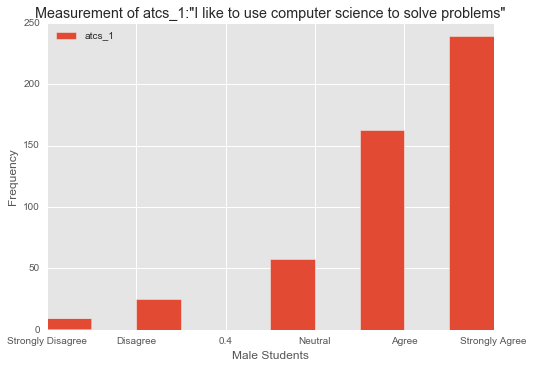

In [49]:

pre_males = dataset.query('gender_Female == 0')
pre_males = pre_males[['atcs_1']]

axes = pre_males.plot.hist()
axes.set_xlabel('Male Students')
axes.set_title('Measurement of atcs_1:"I like to use computer science to solve problems"')
axes.set_yticks(np.arange(0, 300, 50))


a=axes.get_xticks().tolist()
a[0] = 'Strongly Disagree'
a[1] = 'Disagree'
a[3] = 'Neutral'
a[4] = 'Agree'
a[5] = 'Strongly Agree'
axes.set_xticklabels(a);

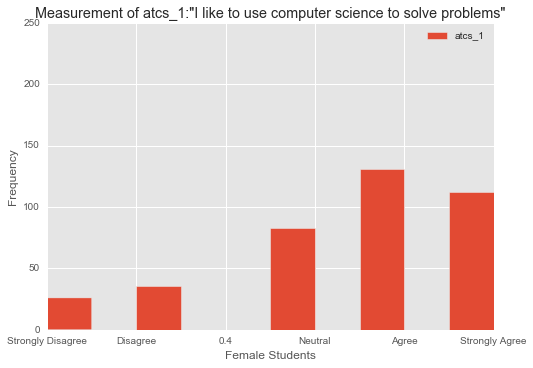

In [50]:
pre_females = dataset.query('gender_Female == 1')
pre_females = pre_females[['atcs_1']]

axes = pre_females.plot.hist()
axes.set_xlabel('Female Students')
axes.set_title('Measurement of atcs_1:"I like to use computer science to solve problems"')
axes.set_yticks(np.arange(0, 300, 50))


a=axes.get_xticks().tolist()
a[0] = 'Strongly Disagree'
a[1] = 'Disagree'
a[3] = 'Neutral'
a[4] = 'Agree'
a[5] = 'Strongly Agree'
axes.set_xticklabels(a);

# Tune Estimator

### Ideal choices of parameters as taken from Xgboost With Python ebook

- Number of Trees (n estimators) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (learning rate) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (subsample) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (colsample bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (min child weight) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (max depth) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (gamma) fixed with a value of zero.


In [73]:
from __future__ import division


X = X_train

In [66]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier as XGBC



print '_'*20, 'Tuning XGBoost', '_'*20
print "Training the data"


cv_params = {'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4, 6, 8, 10],
            'n_estimators': range(100, 1100, 100)}
             



# Build a stratified shuffle object because of unbalanced data
folds = 10
ssscv = StratifiedShuffleSplit(y_train, folds, random_state = seed)

# Make an appropriate scoring function
scoring_function = make_scorer(f1_score)


grid = GridSearchCV(XGBC(), cv_params, cv=ssscv, scoring=scoring_function, n_jobs = -1) 
grid.fit(X, y_train)


____________________ Tuning XGBoost ____________________
Training the data


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  1. ...,  0.  0.], n_iter=10, test_size=0.1, random_state=342),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888], 'max_depth': [4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(f1_score),
       verbose=0)

In [63]:
print "Best accuracy obtained: {0}".format(grid.best_score_)
print "Parameters:"
for key, value in grid.best_params_.items():
    print "\t{}: {}".format(key, value)
    



Best accuracy obtained: 0.568844388819
Parameters:
	n_estimators: 200
	learning_rate: 0.4444
	max_depth: 6


In [65]:
Features_test = X_test


# make predictions for test data
y_pred = model.predict(Features_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.27%


## Save Model

In [ ]:
import pickle

# save model to file
pickle.dump(model, open("genderedCSExperience.pickle.dat", "wb"))

In [ ]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, rankdir='LR')
g.render('report/figures/Tuned_model_graph.gv', view=True)